In [1]:
# 画像が保存されているディレクトリのパス
image_root_dir = "./image/files/"
# 分類カテゴリ（画像が保存されているフォルダ名とイコールになる）
categories = ["醤油ラーメン","味噌ラーメン","担々麺"]

# ラベリングによる学習/検証データの準備

In [2]:
from PIL import Image
from functools import partial
import os, glob
import numpy as np
import random, math

# monkey patch
np.load = partial(np.load, allow_pickle=True)

# 画像データ用配列
X = []
# ラベルデータ用配列
Y = []

# 画像データごとにadd_sample()を呼び出し、X,Yの配列を返す関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

# 渡された画像データを読み込んでXに格納し、また、
# 画像データに対応するcategoriesのidxをY格納する関数
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((256, 256))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

# 全データ格納用配列
allfiles = []

# カテゴリ配列の各値と、それに対応するidxを認識し、全データをallfilesにまとめる
for idx, cat in enumerate(categories):
    image_dir = image_root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for f in files:
        allfiles.append((idx, f))

# シャッフル後、学習データと検証データに分ける
random.shuffle(allfiles)
th = math.floor(len(allfiles) * 0.8)
train = allfiles[0:th]
test  = allfiles[th:]
X_train, y_train = make_sample(train)
X_test, y_test = make_sample(test)
xy = (X_train, X_test, y_train, y_test)

# データを保存する
np.save("./data/my_data.npy", xy)
print("saved.")

saved.


# モデルの構築

In [3]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(len(categories), activation="sigmoid")) # 分類先の種類分設定

# モデル構成の確認
model.summary()

Using TensorFlow backend.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)  

# モデルのコンパイル

In [4]:
from keras import optimizers

model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=["acc"])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# データの準備

In [5]:
from keras.utils import np_utils
import numpy as np

nb_classes = len(categories)

X_train, X_test, y_train, y_test = np.load("./data/my_data.npy")

# データの正規化
X_train = X_train.astype("float") / 255
X_test  = X_test.astype("float")  / 255

# kerasで扱えるようにcategoriesをベクトルに変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test  = np_utils.to_categorical(y_test, nb_classes)

# モデルの学習

In [6]:
model = model.fit(X_train,
                  y_train,
                  epochs=8, # 何回学習を繰り返すか
                  batch_size=6, # データを何個ずつのサブセットに分けて学習するか
                  validation_data=(X_test, y_test))


Train on 201 samples, validate on 51 samples
Epoch 1/8
201/201 [==============================] - 16s 79ms/step - loss: 0.6437 - acc: 0.6633 - val_loss: 0.6965 - val_acc: 0.6144
Epoch 2/8
201/201 [==============================] - 16s 79ms/step - loss: 0.5907 - acc: 0.6833 - val_loss: 0.5676 - val_acc: 0.7190
Epoch 3/8
201/201 [==============================] - 16s 80ms/step - loss: 0.5342 - acc: 0.7131 - val_loss: 0.5780 - val_acc: 0.6993
Epoch 4/8
201/201 [==============================] - 16s 81ms/step - loss: 0.4849 - acc: 0.7629 - val_loss: 0.7045 - val_acc: 0.5686
Epoch 5/8
201/201 [==============================] - 16s 78ms/step - loss: 0.4194 - acc: 0.7944 - val_loss: 0.7563 - val_acc: 0.6013
Epoch 6/8
201/201 [==============================] - 16s 77ms/step - loss: 0.3828 - acc: 0.8358 - val_loss: 1.3393 - val_acc: 0.5686
Epoch 7/8
201/201 [==============================] - 15s 76ms/step - loss: 0.3633 - acc: 0.8408 - val_loss: 1.1633 - val_acc: 0.5098
Epoch 8/8
201/201 [====

# 学習結果を表示

<module 'matplotlib.pyplot' from 'C:\\Users\\sakurai\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


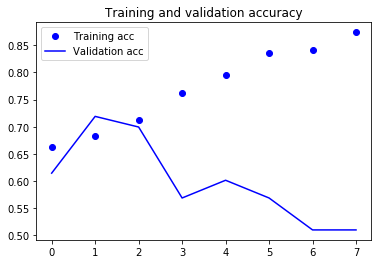

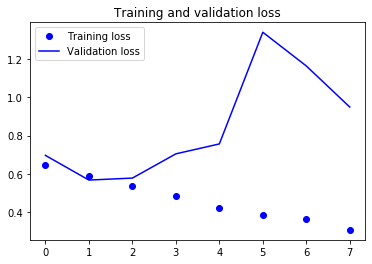

In [12]:
import matplotlib.pyplot as plt

acc = model.history['acc']
val_acc = model.history['val_acc']
loss = model.history['loss']
val_loss = model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('./data/accuracy.png')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('./data/loss.png')
print(plt)

# モデル・重みの保存

In [8]:
# モデル
json_string = model.model.to_json()
open('./data/my_predict.json', 'w').write(json_string)

# 重み
hdf5_file = "./data/my_predict.hdf5"
model.model.save_weights(hdf5_file)
print("saved.")